In [14]:
!pip install torchvision

  Using cached torchvision-0.22.0-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
Using cached torchvision-0.22.0-cp313-cp313-win_amd64.whl (1.7 MB)



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import nibabel as nib
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# Replace with your local path to data folder
filepath = "C:/Users/Jared/Downloads/OneDrive_2025-04-08/CSCI 5931 Project Data/"

# Load the 3 fMRI dataset from the .nii files
decrease_data = nib.load(os.path.join(filepath, 'Rbucket_ER_decrease.nii'))
neutral_data = nib.load(os.path.join(filepath, 'Rbucket_ER_neutral.nii'))
negative_data = nib.load(os.path.join(filepath, 'Rbucket_ER_lookneg.nii'))

# Load the brain mask
mask = nib.load(os.path.join(filepath,'mask2.nii'))
mask_img = mask.get_fdata()

# Extract the actual image data (3D numpy arrays)
decrease_img = decrease_data.get_fdata()
neutral_img = neutral_data.get_fdata()
negative_img = negative_data.get_fdata()

# Get the dimensions
## Note: 82 subjects
print("Data dimensions (decrease):", decrease_img.shape)
print("Data dimensions (neutral):", neutral_img.shape)
print("Data dimensions (negative):", negative_img.shape)
print("Data dimensions (mask):", mask_img.shape)

# Add singleton dimensions to mask to match dimensions
mask_data = mask.get_fdata()[..., np.newaxis, np.newaxis]  # shape becomes (64, 76, 64, 1, 1)

# Apply mask to images 
decrease_img = decrease_img * mask_data
neutral_img = neutral_img * mask_data
negative_img = negative_img * mask_data

# Transpose to (subjects, x, y, z, channel)
decrease = np.transpose(decrease_img, (4, 0, 1, 2, 3))  # shape: (82, 64, 76, 64, 1)
neutral = np.transpose(neutral_img, (4, 0, 1, 2, 3))
negative = np.transpose(negative_img, (4, 0, 1, 2, 3))

# Stack images
X = np.concatenate([decrease, neutral, negative], axis=0)  # shape: (3*82, 64, 76, 64, 1)

# Create labels
y = np.array([0]*82 + [1]*82 + [2]*82)  # 0=decrease, 1=neutral, 2=negative

# Squeeze channel dimension: PyTorch expects (N, C, D, H, W)
X = np.transpose(X, (0, 4, 1, 2, 3))  # (N, 1, 64, 76, 64)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


Data dimensions (decrease): (64, 76, 64, 1, 82)
Data dimensions (neutral): (64, 76, 64, 1, 82)
Data dimensions (negative): (64, 76, 64, 1, 82)
Data dimensions (mask): (64, 76, 64)


In [7]:
# Define CNN Architecture
import torch.nn as nn
import torch.nn.functional as F

class fMRICNN(nn.Module):
    def __init__(self):
        super(fMRICNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)
        
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)
        
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool3d(2)

        self.flatten_dim = 64 * 8 * 9 * 8  # Depends on input size: (64,76,64) → 3x pooling

        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 3)  # 3 classes

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # -> (16, 32, 38, 32)
        x = self.pool2(F.relu(self.conv2(x)))  # -> (32, 16, 19, 16)
        x = self.pool3(F.relu(self.conv3(x)))  # -> (64, 8, 9, 8)
        x = x.view(-1, self.flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class Small3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.Dropout3d(0.3)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv3d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.Dropout3d(0.4)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)  # Output: (N, 32, 1, 1, 1)
        )
        self.fc = nn.Linear(32, 3)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [11]:
# Train the model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Split dataset 
train_size = int(0.8 * len(dataset)) # 5-fold
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = fMRICNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# For tracking loss and accuracy
train_losses = []
val_accuracies = []

# Training loop
for epoch in range(20):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    correct = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_val).sum().item()

    val_acc = correct / len(val_loader.dataset)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

Epoch  1 | Train Loss: 1.1377 | Val Accuracy: 0.2800
Epoch  2 | Train Loss: 1.0527 | Val Accuracy: 0.2800
Epoch  3 | Train Loss: 0.9616 | Val Accuracy: 0.7200
Epoch  4 | Train Loss: 0.7543 | Val Accuracy: 0.8200
Epoch  5 | Train Loss: 0.6425 | Val Accuracy: 0.8400
Epoch  6 | Train Loss: 0.5255 | Val Accuracy: 0.6400
Epoch  7 | Train Loss: 0.5856 | Val Accuracy: 0.7600
Epoch  8 | Train Loss: 0.4228 | Val Accuracy: 0.8200
Epoch  9 | Train Loss: 0.3172 | Val Accuracy: 0.8000
Epoch 10 | Train Loss: 0.3779 | Val Accuracy: 0.7800
Epoch 11 | Train Loss: 0.2499 | Val Accuracy: 0.7400
Epoch 12 | Train Loss: 0.2454 | Val Accuracy: 0.8000
Epoch 13 | Train Loss: 0.1619 | Val Accuracy: 0.7800
Epoch 14 | Train Loss: 0.1537 | Val Accuracy: 0.8000
Epoch 15 | Train Loss: 0.1818 | Val Accuracy: 0.7000
Epoch 16 | Train Loss: 0.1606 | Val Accuracy: 0.7600
Epoch 17 | Train Loss: 0.1476 | Val Accuracy: 0.7800
Epoch 18 | Train Loss: 0.0820 | Val Accuracy: 0.7200
Epoch 19 | Train Loss: 0.0453 | Val Accuracy: 

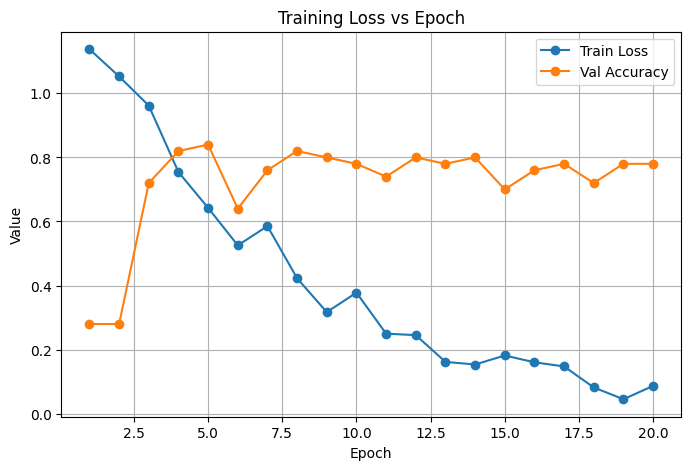

In [19]:
import matplotlib.pyplot as plt

# assume train_losses and val_accuracies are both lists of length 20
epochs = range(1, 21)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss', color='tab:blue')
plt.plot(epochs, val_accuracies, marker='o', label='Val Accuracy', color='tab:orange')
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Try ResNet3D Transfer Learning
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18  # 3D ResNet-18
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader
import numpy as np


model = r3d_18(pretrained=True)

# Modify the first conv layer to accept 1 channel instead of 3
# Original: Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), ...)
model.stem[0] = nn.Conv3d(
    in_channels=1,
    out_channels=64,
    kernel_size=(3, 7, 7),
    stride=(1, 2, 2),
    padding=(1, 3, 3),
    bias=False
)

# Replace the classifier (fully connected layer) for 3 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10  # adjust as needed
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss / len(dataloader):.4f}")

C:\Users\Jared\venv311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jared\venv311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
0.4%

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to C:\Users\Jared/.cache\torch\hub\checkpoints\r3d_18-b3b3357e.pth


100.0%


Epoch 1/10 | Loss: 0.8866
Epoch 2/10 | Loss: 0.5892
Epoch 3/10 | Loss: 0.4145


KeyboardInterrupt: 

In [18]:
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18
from torch.utils.data import random_split, DataLoader, TensorDataset

# --- assume X_tensor, y_tensor already created as in your pipeline ---
dataset = TensorDataset(X_tensor, y_tensor)

# 1) SPLIT into train / val
N = len(dataset)
n_val = int(0.2 * N)           # 20% for validation
n_train = N - n_val
train_ds, val_ds = random_split(dataset, [n_train, n_val], 
                                generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)

# ResNet3D model
model = r3d_18(pretrained=True)

# freeze all pretrained weights
for param in model.parameters():
    param.requires_grad = False

# adapt first conv to 1 channel
model.stem[0] = nn.Conv3d(
    in_channels=1, out_channels=64,
    kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3),
    bias=False
)

# replace final FC; this new layer will be trainable
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 3) LOSS & OPTIMIZER (only the unfrozen params)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-5
)

# 4) TRAIN + VALIDATE each epoch
num_epochs = 10
for epoch in range(num_epochs):
    # ——— Training ———
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    avg_train_loss = running_loss / n_train

    # ——— Validation ———
    model.eval()
    correct = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_val).sum().item()

    val_acc = correct / n_val

    print(f"Epoch {epoch+1:2d} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

Epoch  1 | Train Loss: 0.9831 | Val Acc: 0.3061
Epoch  2 | Train Loss: 0.7971 | Val Acc: 0.4286
Epoch  3 | Train Loss: 0.7431 | Val Acc: 0.6531
Epoch  4 | Train Loss: 0.5687 | Val Acc: 0.7143
Epoch  5 | Train Loss: 0.3116 | Val Acc: 0.7143
Epoch  6 | Train Loss: 0.3258 | Val Acc: 0.6531
Epoch  7 | Train Loss: 0.3795 | Val Acc: 0.7347
Epoch  8 | Train Loss: 0.1938 | Val Acc: 0.7755
Epoch  9 | Train Loss: 0.2394 | Val Acc: 0.7551
Epoch 10 | Train Loss: 0.2279 | Val Acc: 0.6939


In [10]:
import torchvision
print(torchvision.__file__)

AttributeError: partially initialized module 'torchvision' from 'C:\Users\Jared\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\__init__.py' has no attribute 'extension' (most likely due to a circular import)

In [14]:
import matplotlib.pyplot as plt
# Training loss plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), train_losses, marker='o')
plt.title('Training Loss vs Epoch (Frozen Weights ResNet)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Files removed: 0


Looking in indexes: https://download.pytorch.org/whl/cu121


ERROR: Could not find a version that satisfies the requirement torch (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for torch


  Using cached torchvision-0.22.0-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
Using cached torchvision-0.22.0-cp313-cp313-win_amd64.whl (1.7 MB)



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
